# Phase 1: Business Understanding

The primary objective of this project, focused on the application of the CRISP-DM methodology in the context of a wine quality classification problem, is to develop a robust machine learning application. This application aims to accurately classify the quality of Vinho Verde wine samples from Portugal, leveraging physicochemical data. The project sets specific, measurable, actionable, results-oriented, and time-bound (SMART) goals to guide its execution.

In this phase, we establish the business context and the potential impact of the project. The main goal is to create a predictive model that can provide an accuracy rate significantly higher than current industry standards. This would enable winemakers and distributors to make more informed decisions about wine production, marketing strategies, and customer preferences. Key business questions to address include: “How can the quality of wine be predicted more accurately using physicochemical properties?”, “What features most significantly impact wine quality?”, and “How can this model be used to improve wine production and marketing strategies?”

To achieve this, we outline a detailed project plan covering the necessary steps to reach the goal. This includes understanding the datasets of red and white Vinho Verde wines, determining the best machine learning techniques to apply, and evaluating the effectiveness of these techniques in accurately classifying wine quality. We also identify potential constraints, such as the size and completeness of the datasets, and outline risks, such as potential overfitting or biases in the model, along with corresponding mitigation strategies.

This phase sets the foundation for the project, ensuring that all subsequent steps align with the defined business objectives and are executed within a structured framework to maximize the chances of successful project completion.

# Phase 2: Data Preparation

In [58]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

  
# fetch dataset 
wine_quality = fetch_ucirepo(id=186) 
X = wine_quality.data.features 
y = wine_quality.data.targets 

# metadata 
print(wine_quality.metadata) 

# variable information 
print(wine_quality.variables) 


{'uci_id': 186, 'name': 'Wine Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv', 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 4898, 'num_features': 11, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['quality'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Wed Nov 15 2023', 'dataset_doi': '10.24432/C56S3T', 'creators': ['Paulo Cortez', 'A. Cerdeira', 'F. Almeida', 'T. Matos', 'J. Reis'], 'intro_paper': {'title': 'Modeling wine preferences by data mining from physicoc

First step is to get a basic understanding of the data. We can do this by looking at the metadata and variable information. The metadata tells us that the data was collected from two datasets, one for red wine and one for white wine. The variable information tells us that there are 12 features and 1 target variable. The features are all numeric and the target variable is categorical. The target variable is the quality of the wine, which is a score between 0 and 10. The features are all physicochemical properties of the wine, such as pH, alcohol content, and density. There is no missing data in the dataset.

In [59]:
print(wine_quality.data.features.info())
print(wine_quality.data.features.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         6497 non-null   float64
 1   volatile_acidity      6497 non-null   float64
 2   citric_acid           6497 non-null   float64
 3   residual_sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free_sulfur_dioxide   6497 non-null   float64
 6   total_sulfur_dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
dtypes: float64(11)
memory usage: 558.5 KB
None
       fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
count    6497.000000       6497.000000  6497.000000     6497.000000   
mean        7.215307          0.339666  

In [60]:
print(wine_quality.data.targets.info())
print(wine_quality.data.targets.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   quality  6497 non-null   int64
dtypes: int64(1)
memory usage: 50.9 KB
None
           quality
count  6497.000000
mean      5.818378
std       0.873255
min       3.000000
25%       5.000000
50%       6.000000
75%       6.000000
max       9.000000


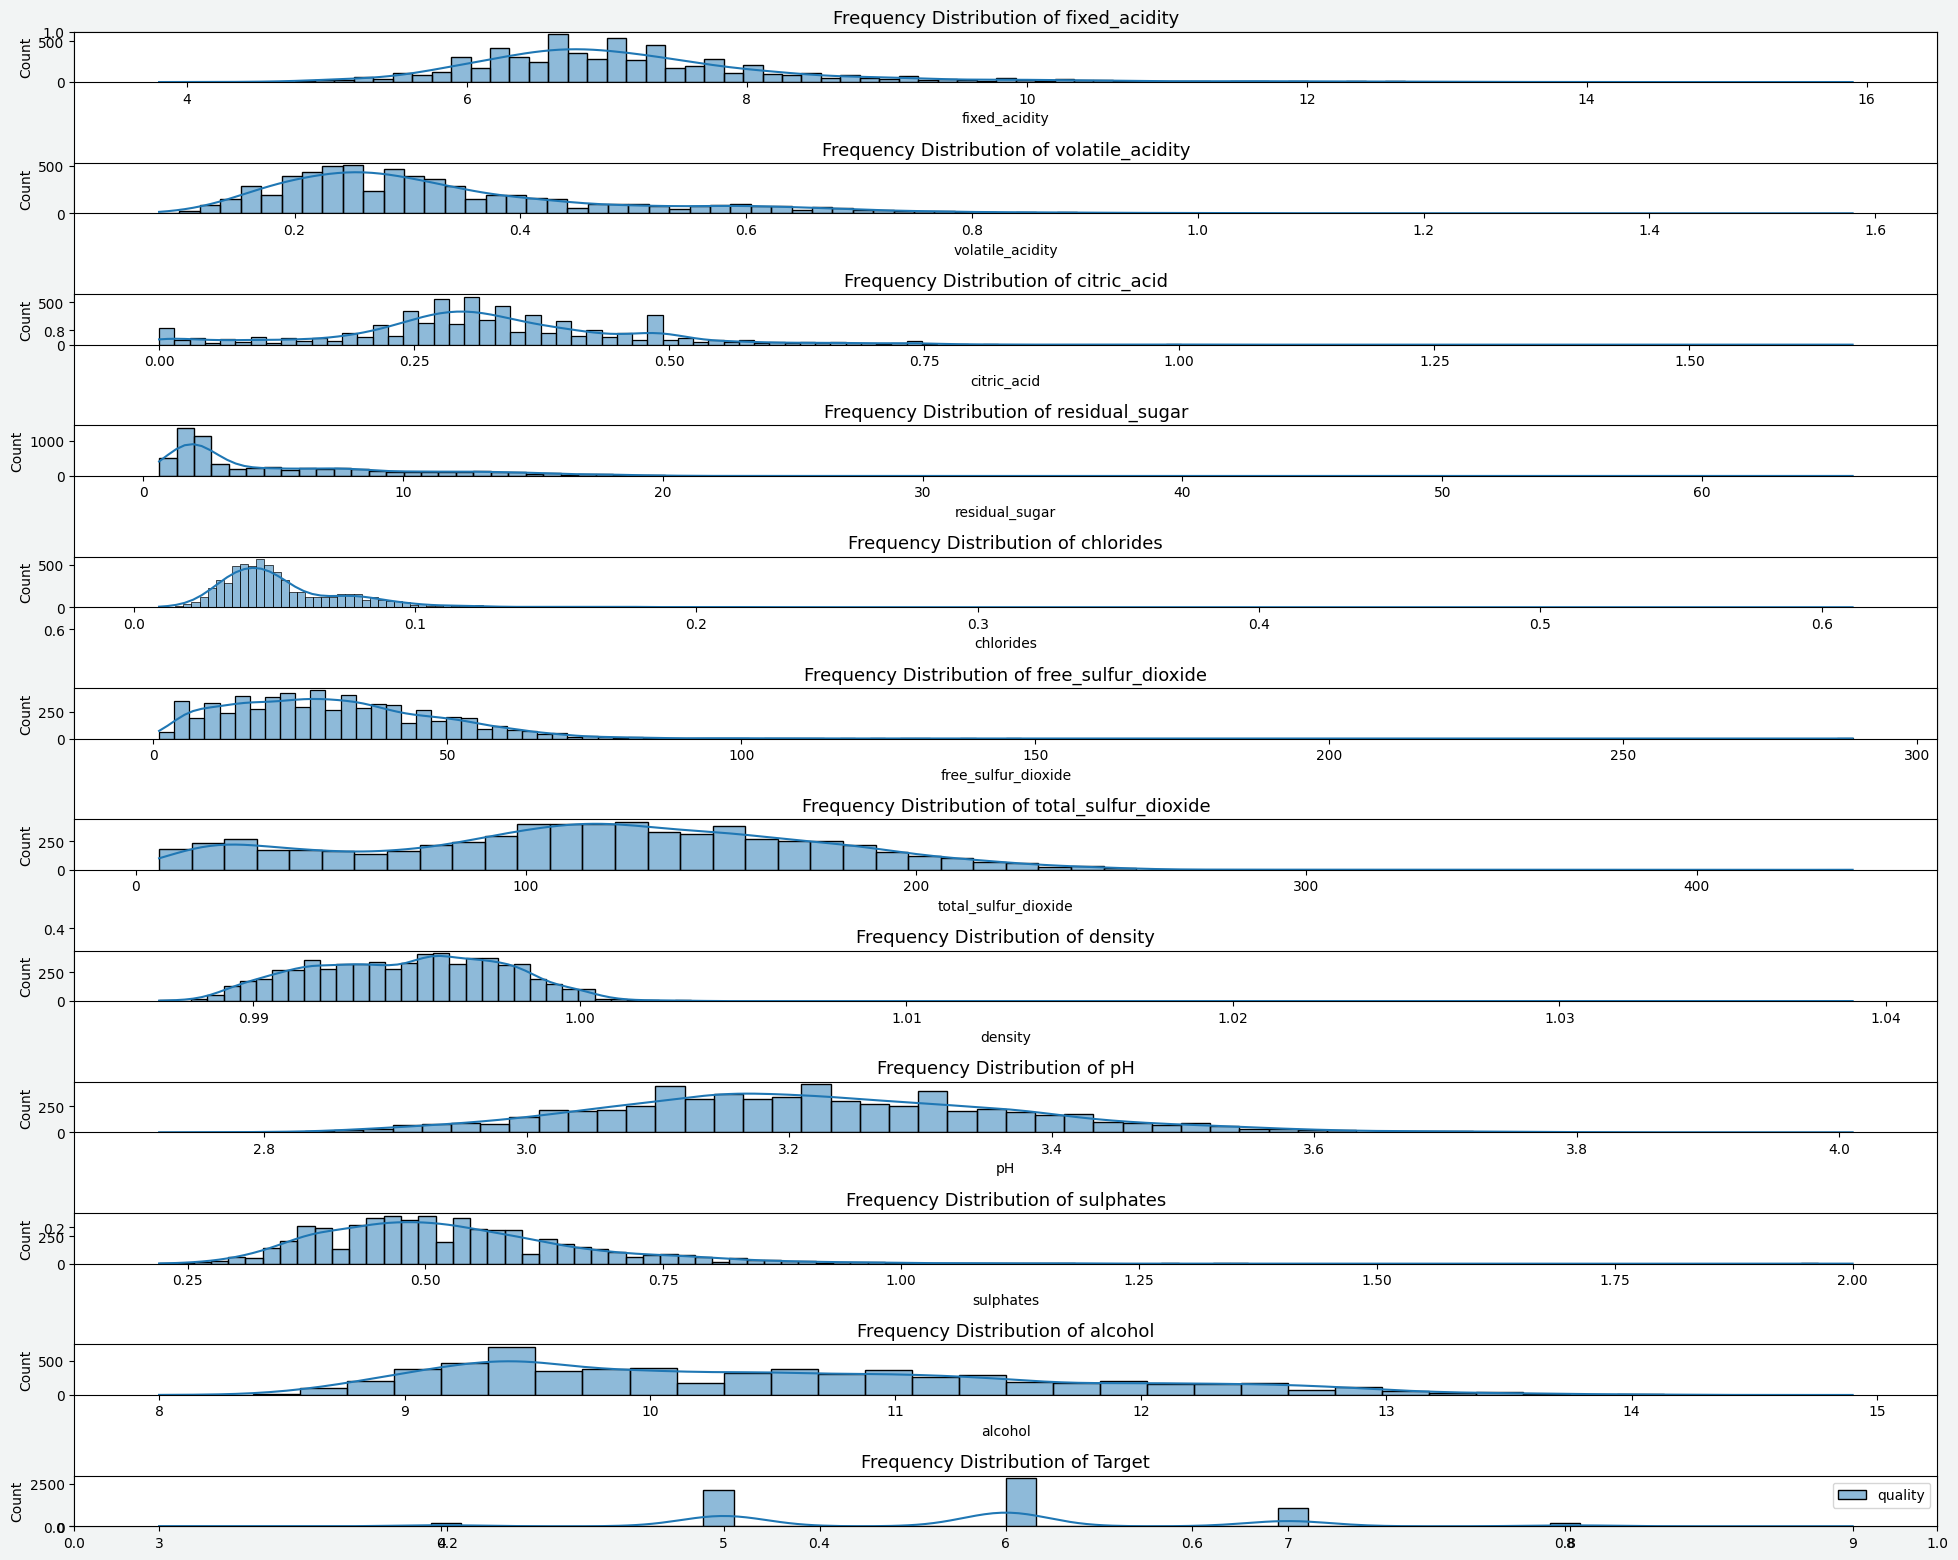

In [61]:
# Exploring the distribution of numeric columns using histograms
fig, ax = plt.subplots(figsize=(20, 16), facecolor='#F2F4F4')
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.5)

# Plotting histograms for features
num_features = X.shape[1]
for i in range(num_features):
    plt.subplot(num_features + 1, 1, i + 1)
    sns.histplot(x=X.iloc[:, i], kde=True)
    plt.title(f'Frequency Distribution of {X.columns[i]}', fontsize=13)

# Plotting histogram for target
plt.subplot(num_features + 1, 1, num_features + 1)
sns.histplot(y, kde=True)
plt.title('Frequency Distribution of Target', fontsize=13)

plt.tight_layout()
plt.show()

From the histograms, we can see that the features and target are not normally distributed. Most of the quality grades are between 5 and 7, with very few samples having a quality grade of 3 or 9. The features also have a wide range of values, so we will need to scale the data before training the model.

In [62]:
# scaler = MinMaxScaler()
# scaled_features = scaler.fit_transform(X)  # replace X with your features DataFrame
# scaled_features_df = pd.DataFrame(scaled_features, columns=X.columns)
# scaled_combined_df = pd.concat([scaled_features_df, y], axis=1)
# scaled_combined_df.head()

Search for a correlation between the features and the target variable. We can do this by plotting a heatmap of the correlation matrix.

                      fixed_acidity  volatile_acidity  citric_acid  \
fixed_acidity              1.000000         -0.256131     0.671703   
volatile_acidity          -0.256131          1.000000    -0.552496   
citric_acid                0.671703         -0.552496     1.000000   
residual_sugar             0.114777          0.001918     0.143577   
chlorides                  0.093705          0.061298     0.203823   
free_sulfur_dioxide       -0.153794         -0.010504    -0.060978   
total_sulfur_dioxide      -0.113181          0.076470     0.035533   
density                    0.668047          0.022026     0.364947   
pH                        -0.682978          0.234937    -0.541904   
sulphates                  0.183006         -0.260987     0.312770   
alcohol                   -0.061668         -0.202288     0.109903   
quality                    0.124052         -0.390558     0.226373   

                      residual_sugar  chlorides  free_sulfur_dioxide  \
fixed_acidity    

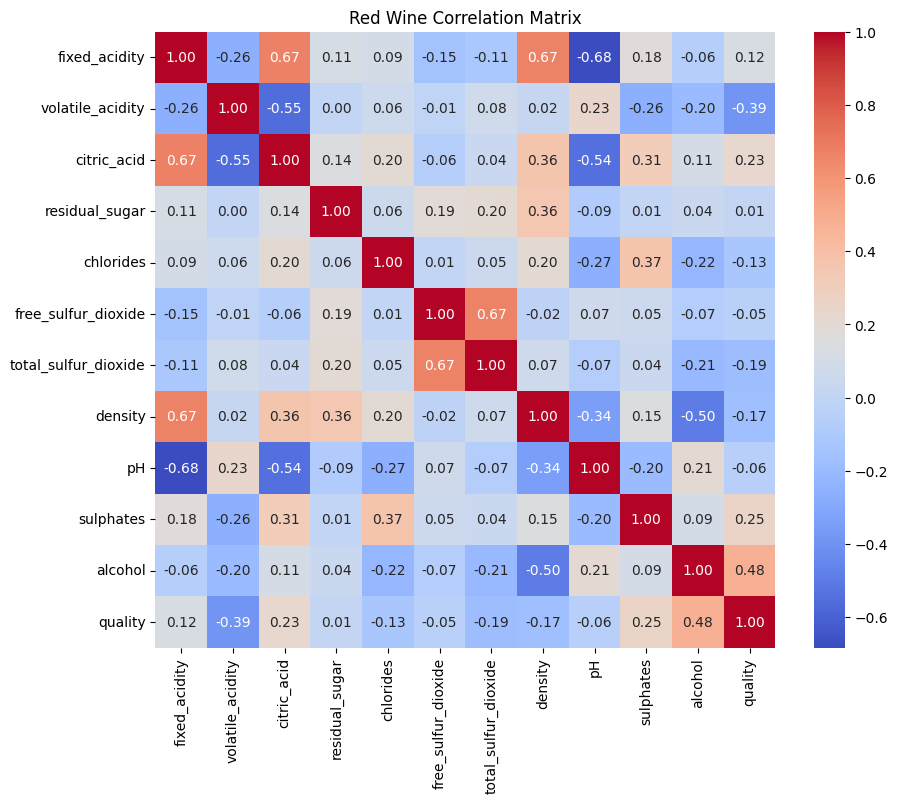

In [63]:
def plot_correlation(X, y, title):
    # Combining features and target into one DataFrame
    combined_df = pd.concat([X, y], axis=1)

    # Computing the correlation matrix
    correlation_matrix = combined_df.corr()
    
    print(correlation_matrix)

    # Plotting the correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title(title)
    plt.show()

# Extracting the original dataset
original_data = wine_quality.data['original']

# Splitting the dataset into red and white wines
red_wine = original_data[original_data['color'] == 'red']
white_wine = original_data[original_data['color'] == 'white']

# Red wine
X_red = red_wine.drop(['quality', 'color'], axis=1)
y_red = red_wine['quality']

# White wine
X_white = white_wine.drop(['quality', 'color'], axis=1)
y_white = white_wine['quality']

# Example usage with red and white wine datasets
plot_correlation(X_red, y_red, "Red Wine Correlation Matrix")

### Interpretation of the correlation matrix

   Alcohol and Quality (0.476166): There is a moderate positive correlation between alcohol content and wine quality. This suggests that higher alcohol levels are generally associated with higher quality red wines.

   Volatile Acidity and Quality (-0.390558): There is a moderate negative correlation between volatile acidity and wine quality. Higher levels of volatile acidity are typically associated with lower wine quality.

   Fixed Acidity and Citric Acid (0.671703): A strong positive correlation, indicating that wines with higher fixed acidity also tend to have higher citric acid levels.

   Fixed Acidity and pH (-0.682978): This strong negative correlation suggests that wines with higher fixed acidity tend to have lower pH levels.

   Citric Acid and Volatile Acidity (-0.552496): There is a significant negative correlation, meaning that wines with higher citric acid content generally have lower volatile acidity.

   Density and Alcohol (-0.496180): A strong negative correlation, indicating that as alcohol content increases, the density of the wine decreases.

   Free Sulfur Dioxide and Total Sulfur Dioxide (0.667666): A strong positive correlation. This indicates that wines with higher levels of free sulfur dioxide also tend to have higher levels of total sulfur dioxide.

   Sulphates and Chlorides (0.371260): A moderate positive correlation, suggesting that higher sulphates in wine are often associated with higher chloride levels.

                      fixed_acidity  volatile_acidity  citric_acid  \
fixed_acidity              1.000000         -0.022697     0.289181   
volatile_acidity          -0.022697          1.000000    -0.149472   
citric_acid                0.289181         -0.149472     1.000000   
residual_sugar             0.089021          0.064286     0.094212   
chlorides                  0.023086          0.070512     0.114364   
free_sulfur_dioxide       -0.049396         -0.097012     0.094077   
total_sulfur_dioxide       0.091070          0.089261     0.121131   
density                    0.265331          0.027114     0.149503   
pH                        -0.425858         -0.031915    -0.163748   
sulphates                 -0.017143         -0.035728     0.062331   
alcohol                   -0.120881          0.067718    -0.075729   
quality                   -0.113663         -0.194723    -0.009209   

                      residual_sugar  chlorides  free_sulfur_dioxide  \
fixed_acidity    

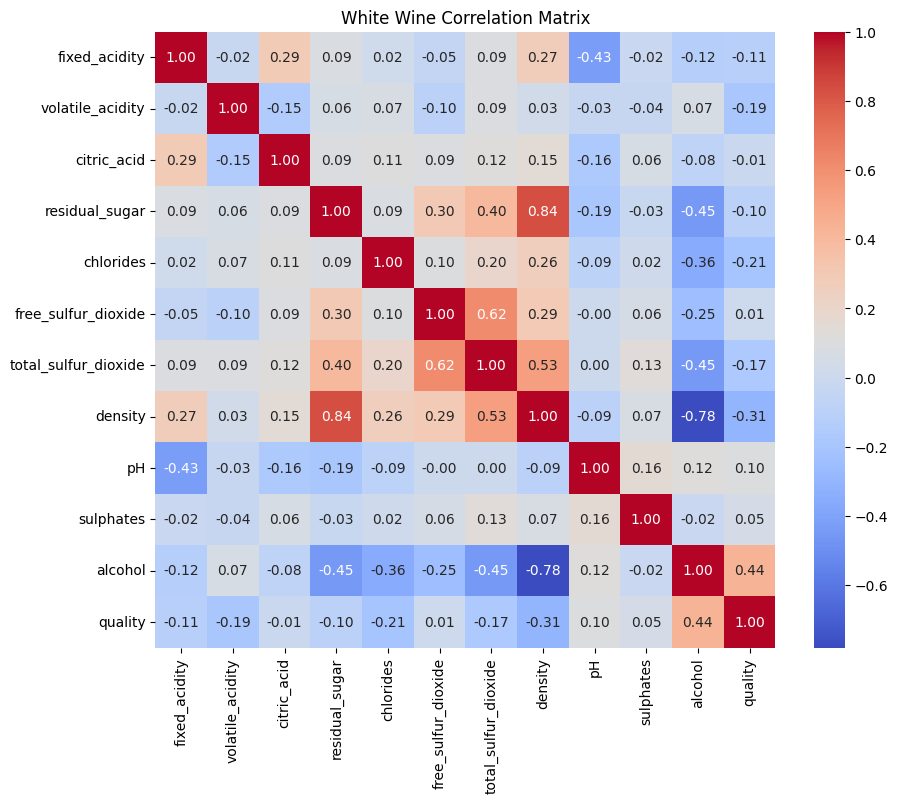

In [64]:
plot_correlation(X_white, y_white, "White Wine Correlation Matrix")

Alcohol and Quality (0.435575): Similar to red wine, there is a moderate positive correlation between alcohol content and wine quality in white wines, indicating that wines with higher alcohol levels generally have higher quality ratings.

   Volatile Acidity and Quality (-0.194723): This shows a moderate negative correlation. In white wines, higher levels of volatile acidity are generally associated with a lower quality rating, although this correlation is not as strong as in red wines.

   Density and Alcohol (-0.780138): A very strong negative correlation, suggesting that as alcohol content increases, the density of the wine decreases, more pronounced than in red wines.

   Residual Sugar and Density (0.838966): There is a very strong positive correlation between residual sugar and density in white wines, which is higher compared to red wines. This indicates that white wines with higher sugar content tend to be denser.

   Total Sulfur Dioxide and Free Sulfur Dioxide (0.615501): This strong positive correlation is similar to red wines, indicating that white wines with higher levels of free sulfur dioxide also tend to have higher total sulfur dioxide levels.

   pH and Fixed Acidity (-0.425858): A strong negative correlation, similar to red wines, shows that white wines with higher acidity tend to have a lower pH.

   Chlorides and Quality (-0.209934): Indicates a moderate negative correlation in white wines, suggesting that higher chloride levels might be associated with lower quality.

   Citric Acid and Volatile Acidity (-0.149472): Shows a moderate negative correlation, suggesting that white wines with higher citric acid content tend to have lower volatile acidity.

# Phase 3: Modeling

In [65]:
def run_experiment(X, y, missing_rate=0, impute_strategy='mean', scale_data=False, reduce_data=False):
    # Introduce missing values
    X_missing = X.copy()
    n_missing = int(missing_rate * X_missing.size)
    missing_indices = np.random.choice(X_missing.size, n_missing, replace=False)
    X_missing.values.ravel()[missing_indices] = np.nan

    # Impute missing values
    imputer = SimpleImputer(strategy=impute_strategy)
    X_imputed = imputer.fit_transform(X_missing)

    # Data scaling
    if scale_data:
        scaler = MinMaxScaler()  # Or use StandardScaler
        X_imputed = scaler.fit_transform(X_imputed)

    # Data reduction (PCA)
    if reduce_data:
        pca = PCA(n_components=0.95)  # Keeping 95% of variance
        X_imputed = pca.fit_transform(X_imputed)

    # Splitting the dataset
    X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

    # Creating and training the MLP model
    mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
    mlp.fit(X_train, y_train)

    # Predictions and evaluation
    y_pred = mlp.predict(X_test)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    return mlp


# Experiment settings
missing_rates = [0.1, 0.2, 0.3]  # 10%, 20%, 30%
impute_strategies = ['mean', 'median']
normalize_data = [False, True]
reduce_data = [False, True]

# Running experiments for each combination
for missing_rate in missing_rates:
    for strategy in impute_strategies:
        for normalize in normalize_data:
            for reduce in reduce_data:
                print(f"Red Wine - Missing: {missing_rate}, Impute: {strategy}, Normalize: {normalize}, Reduce: {reduce}")
                run_experiment(X_red, y_red, missing_rate, strategy, normalize, reduce)
                print(f"White Wine - Missing: {missing_rate}, Impute: {strategy}, Normalize: {normalize}, Reduce: {reduce}")
                run_experiment(X_white, y_white, missing_rate, strategy, normalize, reduce)


Red Wine - Missing: 0.1, Impute: mean, Normalize: False, Reduce: False
[[  0   0   1   0   0   0]
 [  0   0  10   0   0   0]
 [  0   0 115  14   1   0]
 [  0   0  82  37  13   0]
 [  0   0   9  23  10   0]
 [  0   0   0   3   2   0]]
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        10
           5       0.53      0.88      0.66       130
           6       0.48      0.28      0.35       132
           7       0.38      0.24      0.29        42
           8       0.00      0.00      0.00         5

    accuracy                           0.51       320
   macro avg       0.23      0.23      0.22       320
weighted avg       0.46      0.51      0.45       320

White Wine - Missing: 0.1, Impute: mean, Normalize: False, Reduce: False


/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

[[  1   0   3   1   0   0]
 [  0   1  18   6   0   0]
 [  0   2 135 152   2   0]
 [  0   0  82 340  10   0]
 [  0   0  11 170   9   2]
 [  0   0   3  26   6   0]]
              precision    recall  f1-score   support

           3       1.00      0.20      0.33         5
           4       0.33      0.04      0.07        25
           5       0.54      0.46      0.50       291
           6       0.49      0.79      0.60       432
           7       0.33      0.05      0.08       192
           8       0.00      0.00      0.00        35

    accuracy                           0.50       980
   macro avg       0.45      0.26      0.26       980
weighted avg       0.45      0.50      0.43       980

Red Wine - Missing: 0.1, Impute: mean, Normalize: False, Reduce: True
[[ 0  0  0  1  0  0]
 [ 0  0  3  7  0  0]
 [ 0  0 64 66  0  0]
 [ 0  0 44 88  0  0]
 [ 0  0  8 34  0  0]
 [ 0  0  1  4  0  0]]
              precision    recall  f1-score   support

           3       0.00      0.00      0.0

/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

[[  0   1   3   1   0   0]
 [  0   0  18   6   1   0]
 [  0   3 132 150   6   0]
 [  0   0 115 308   9   0]
 [  0   0  35 154   3   0]
 [  0   0   4  30   1   0]]
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00        25
           5       0.43      0.45      0.44       291
           6       0.47      0.71      0.57       432
           7       0.15      0.02      0.03       192
           8       0.00      0.00      0.00        35

    accuracy                           0.45       980
   macro avg       0.18      0.20      0.17       980
weighted avg       0.37      0.45      0.39       980

Red Wine - Missing: 0.1, Impute: mean, Normalize: True, Reduce: False


/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

[[ 0  0  1  0  0  0]
 [ 0  0  9  1  0  0]
 [ 0  0 97 32  1  0]
 [ 0  0 45 78  9  0]
 [ 0  0  2 32  8  0]
 [ 0  0  0  1  4  0]]
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        10
           5       0.63      0.75      0.68       130
           6       0.54      0.59      0.57       132
           7       0.36      0.19      0.25        42
           8       0.00      0.00      0.00         5

    accuracy                           0.57       320
   macro avg       0.26      0.25      0.25       320
weighted avg       0.53      0.57      0.54       320

White Wine - Missing: 0.1, Impute: mean, Normalize: True, Reduce: False


/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[[  1   0   2   2   0   0]
 [  0   2  18   5   0   0]
 [  0   5 174 109   3   0]
 [  1   0 102 294  35   0]
 [  0   0   7 121  62   2]
 [  0   0   1  22  12   0]]
              precision    recall  f1-score   support

           3       0.50      0.20      0.29         5
           4       0.29      0.08      0.12        25
           5       0.57      0.60      0.58       291
           6       0.53      0.68      0.60       432
           7       0.55      0.32      0.41       192
           8       0.00      0.00      0.00        35

    accuracy                           0.54       980
   macro avg       0.41      0.31      0.33       980
weighted avg       0.52      0.54      0.52       980

Red Wine - Missing: 0.1, Impute: mean, Normalize: True, Reduce: True


/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/pyt

[[  0   0   1   0   0   0]
 [  0   0  10   0   0   0]
 [  0   0 100  29   1   0]
 [  0   0  42  77  13   0]
 [  0   0   2  25  15   0]
 [  0   0   0   2   3   0]]
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        10
           5       0.65      0.77      0.70       130
           6       0.58      0.58      0.58       132
           7       0.47      0.36      0.41        42
           8       0.00      0.00      0.00         5

    accuracy                           0.60       320
   macro avg       0.28      0.28      0.28       320
weighted avg       0.56      0.60      0.58       320

White Wine - Missing: 0.1, Impute: mean, Normalize: True, Reduce: True


/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[[  1   0   1   3   0   0]
 [  0   4  13   8   0   0]
 [  0   2 169 113   6   1]
 [  0   0  96 297  39   0]
 [  0   0   5 124  62   1]
 [  0   0   0  19  16   0]]
              precision    recall  f1-score   support

           3       1.00      0.20      0.33         5
           4       0.67      0.16      0.26        25
           5       0.60      0.58      0.59       291
           6       0.53      0.69      0.60       432
           7       0.50      0.32      0.39       192
           8       0.00      0.00      0.00        35

    accuracy                           0.54       980
   macro avg       0.55      0.33      0.36       980
weighted avg       0.53      0.54      0.52       980

Red Wine - Missing: 0.1, Impute: median, Normalize: False, Reduce: False
[[  0   0   1   0   0   0]
 [  0   0  10   0   0   0]
 [  0   0 105  23   2   0]
 [  0   0  55  67  10   0]
 [  0   0   6  24  12   0]
 [  0   0   0   3   2   0]]
              precision    recall  f1-score   support

   

/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

[[  0   1   3   1   0   0]
 [  0   2  15   8   0   0]
 [  0   1 119 167   4   0]
 [  0   0  85 314  33   0]
 [  0   0  17 141  34   0]
 [  0   0   3  20  12   0]]
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.50      0.08      0.14        25
           5       0.49      0.41      0.45       291
           6       0.48      0.73      0.58       432
           7       0.41      0.18      0.25       192
           8       0.00      0.00      0.00        35

    accuracy                           0.48       980
   macro avg       0.31      0.23      0.24       980
weighted avg       0.45      0.48      0.44       980

Red Wine - Missing: 0.1, Impute: median, Normalize: False, Reduce: True


/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

[[ 0  0  0  1  0  0]
 [ 0  0  4  6  0  0]
 [ 0  0 68 62  0  0]
 [ 0  0 57 75  0  0]
 [ 0  0  9 33  0  0]
 [ 0  0  1  4  0  0]]
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        10
           5       0.49      0.52      0.51       130
           6       0.41      0.57      0.48       132
           7       0.00      0.00      0.00        42
           8       0.00      0.00      0.00         5

    accuracy                           0.45       320
   macro avg       0.15      0.18      0.16       320
weighted avg       0.37      0.45      0.40       320

White Wine - Missing: 0.1, Impute: median, Normalize: False, Reduce: True


/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

[[  1   0   1   3   0   0]
 [  0   1  10  14   0   0]
 [  0   0  92 199   0   0]
 [  0   0  76 355   1   0]
 [  0   0  19 173   0   0]
 [  0   0   2  33   0   0]]
              precision    recall  f1-score   support

           3       1.00      0.20      0.33         5
           4       1.00      0.04      0.08        25
           5       0.46      0.32      0.37       291
           6       0.46      0.82      0.59       432
           7       0.00      0.00      0.00       192
           8       0.00      0.00      0.00        35

    accuracy                           0.46       980
   macro avg       0.49      0.23      0.23       980
weighted avg       0.37      0.46      0.37       980

Red Wine - Missing: 0.1, Impute: median, Normalize: True, Reduce: False


/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

[[  0   0   1   0   0   0]
 [  0   0  10   0   0   0]
 [  0   0 101  28   1   0]
 [  0   0  42  83   7   0]
 [  0   0   2  29  11   0]
 [  0   0   0   1   4   0]]
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        10
           5       0.65      0.78      0.71       130
           6       0.59      0.63      0.61       132
           7       0.48      0.26      0.34        42
           8       0.00      0.00      0.00         5

    accuracy                           0.61       320
   macro avg       0.29      0.28      0.28       320
weighted avg       0.57      0.61      0.58       320

White Wine - Missing: 0.1, Impute: median, Normalize: True, Reduce: False


/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[[  1   0   1   3   0   0]
 [  1   1  15   8   0   0]
 [  0   2 165 118   6   0]
 [  1   0  83 294  54   0]
 [  0   0   4 114  72   2]
 [  0   0   1  17  17   0]]
              precision    recall  f1-score   support

           3       0.33      0.20      0.25         5
           4       0.33      0.04      0.07        25
           5       0.61      0.57      0.59       291
           6       0.53      0.68      0.60       432
           7       0.48      0.38      0.42       192
           8       0.00      0.00      0.00        35

    accuracy                           0.54       980
   macro avg       0.38      0.31      0.32       980
weighted avg       0.52      0.54      0.52       980

Red Wine - Missing: 0.1, Impute: median, Normalize: True, Reduce: True


/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/pyt

[[  0   0   1   0   0   0]
 [  0   0   9   1   0   0]
 [  0   0 100  29   1   0]
 [  0   0  44  78  10   0]
 [  0   0   1  28  13   0]
 [  0   0   0   2   3   0]]
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        10
           5       0.65      0.77      0.70       130
           6       0.57      0.59      0.58       132
           7       0.48      0.31      0.38        42
           8       0.00      0.00      0.00         5

    accuracy                           0.60       320
   macro avg       0.28      0.28      0.28       320
weighted avg       0.56      0.60      0.57       320

White Wine - Missing: 0.1, Impute: median, Normalize: True, Reduce: True


/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/pyt

[[  0   0   1   4   0   0]
 [  0   2  13  10   0   0]
 [  0   4 163 119   5   0]
 [  1   0  90 305  36   0]
 [  0   0   6 131  55   0]
 [  0   0   0  21  14   0]]
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.33      0.08      0.13        25
           5       0.60      0.56      0.58       291
           6       0.52      0.71      0.60       432
           7       0.50      0.29      0.36       192
           8       0.00      0.00      0.00        35

    accuracy                           0.54       980
   macro avg       0.32      0.27      0.28       980
weighted avg       0.51      0.54      0.51       980

Red Wine - Missing: 0.2, Impute: mean, Normalize: False, Reduce: False
[[ 0  0  1  0  0  0]
 [ 0  0 10  0  0  0]
 [ 0  0 94 34  2  0]
 [ 0  0 47 81  4  0]
 [ 0  0  5 33  4  0]
 [ 0  0  0  4  1  0]]
              precision    recall  f1-score   support

           3       0.00      0.00      0.

/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

[[  1   0   3   1   0   0]
 [  0   0  22   2   1   0]
 [  0   2 188  92   9   0]
 [  0   0 153 231  48   0]
 [  0   0  29 120  43   0]
 [  0   0   3  17  15   0]]
              precision    recall  f1-score   support

           3       1.00      0.20      0.33         5
           4       0.00      0.00      0.00        25
           5       0.47      0.65      0.55       291
           6       0.50      0.53      0.52       432
           7       0.37      0.22      0.28       192
           8       0.00      0.00      0.00        35

    accuracy                           0.47       980
   macro avg       0.39      0.27      0.28       980
weighted avg       0.44      0.47      0.45       980

Red Wine - Missing: 0.2, Impute: mean, Normalize: False, Reduce: True


/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

[[ 0  0  0  1  0  0]
 [ 0  0  3  7  0  0]
 [ 0  0 67 63  0  0]
 [ 0  0 49 83  0  0]
 [ 0  0  9 33  0  0]
 [ 0  0  1  4  0  0]]
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        10
           5       0.52      0.52      0.52       130
           6       0.43      0.63      0.51       132
           7       0.00      0.00      0.00        42
           8       0.00      0.00      0.00         5

    accuracy                           0.47       320
   macro avg       0.16      0.19      0.17       320
weighted avg       0.39      0.47      0.42       320

White Wine - Missing: 0.2, Impute: mean, Normalize: False, Reduce: True


/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

[[  1   0   1   3   0   0]
 [  1   0   9  15   0   0]
 [  0   0  95 196   0   0]
 [  0   0  81 351   0   0]
 [  0   0  25 167   0   0]
 [  0   0   1  34   0   0]]
              precision    recall  f1-score   support

           3       0.50      0.20      0.29         5
           4       0.00      0.00      0.00        25
           5       0.45      0.33      0.38       291
           6       0.46      0.81      0.59       432
           7       0.00      0.00      0.00       192
           8       0.00      0.00      0.00        35

    accuracy                           0.46       980
   macro avg       0.23      0.22      0.21       980
weighted avg       0.34      0.46      0.37       980

Red Wine - Missing: 0.2, Impute: mean, Normalize: True, Reduce: False


/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

[[  0   0   1   0   0   0]
 [  0   0   9   1   0   0]
 [  0   0 101  28   1   0]
 [  0   0  44  80   8   0]
 [  0   0   3  29  10   0]
 [  0   0   0   1   4   0]]
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        10
           5       0.64      0.78      0.70       130
           6       0.58      0.61      0.59       132
           7       0.43      0.24      0.31        42
           8       0.00      0.00      0.00         5

    accuracy                           0.60       320
   macro avg       0.27      0.27      0.27       320
weighted avg       0.55      0.60      0.57       320

White Wine - Missing: 0.2, Impute: mean, Normalize: True, Reduce: False


/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/pyt

[[  1   0   2   2   0   0]
 [  0   1  15   9   0   0]
 [  0   3 168 115   5   0]
 [  1   0  85 301  45   0]
 [  0   0   6 117  69   0]
 [  0   0   1  17  17   0]]
              precision    recall  f1-score   support

           3       0.50      0.20      0.29         5
           4       0.25      0.04      0.07        25
           5       0.61      0.58      0.59       291
           6       0.54      0.70      0.61       432
           7       0.51      0.36      0.42       192
           8       0.00      0.00      0.00        35

    accuracy                           0.55       980
   macro avg       0.40      0.31      0.33       980
weighted avg       0.52      0.55      0.53       980

Red Wine - Missing: 0.2, Impute: mean, Normalize: True, Reduce: True


/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/pyt

[[ 0  0  1  0  0  0]
 [ 0  0  9  1  0  0]
 [ 0  0 99 29  2  0]
 [ 0  0 44 79  9  0]
 [ 0  0  3 25 14  0]
 [ 0  0  0  2  3  0]]
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        10
           5       0.63      0.76      0.69       130
           6       0.58      0.60      0.59       132
           7       0.50      0.33      0.40        42
           8       0.00      0.00      0.00         5

    accuracy                           0.60       320
   macro avg       0.29      0.28      0.28       320
weighted avg       0.56      0.60      0.58       320

White Wine - Missing: 0.2, Impute: mean, Normalize: True, Reduce: True


/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[[  1   0   1   3   0   0]
 [  0   4  12   9   0   0]
 [  1   4 160 124   2   0]
 [  1   0  81 315  35   0]
 [  0   0   4 129  56   3]
 [  0   0   0  21  14   0]]
              precision    recall  f1-score   support

           3       0.33      0.20      0.25         5
           4       0.50      0.16      0.24        25
           5       0.62      0.55      0.58       291
           6       0.52      0.73      0.61       432
           7       0.52      0.29      0.37       192
           8       0.00      0.00      0.00        35

    accuracy                           0.55       980
   macro avg       0.42      0.32      0.34       980
weighted avg       0.53      0.55      0.52       980

Red Wine - Missing: 0.2, Impute: median, Normalize: False, Reduce: False
[[ 0  0  1  0  0  0]
 [ 0  0  9  1  0  0]
 [ 0  0 84 43  3  0]
 [ 0  1 29 90 12  0]
 [ 0  0  1 30 11  0]
 [ 0  0  0  3  2  0]]
              precision    recall  f1-score   support

           3       0.00      0.00      

/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

[[  1   0   3   1   0   0]
 [  0   0  21   4   0   0]
 [  0   2 160 128   1   0]
 [  0   0  99 322  11   0]
 [  0   0  18 162  12   0]
 [  0   0   3  27   5   0]]
              precision    recall  f1-score   support

           3       1.00      0.20      0.33         5
           4       0.00      0.00      0.00        25
           5       0.53      0.55      0.54       291
           6       0.50      0.75      0.60       432
           7       0.41      0.06      0.11       192
           8       0.00      0.00      0.00        35

    accuracy                           0.51       980
   macro avg       0.41      0.26      0.26       980
weighted avg       0.46      0.51      0.45       980

Red Wine - Missing: 0.2, Impute: median, Normalize: False, Reduce: True


/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

[[ 0  0  0  1  0  0]
 [ 0  0  6  4  0  0]
 [ 0  0 85 45  0  0]
 [ 0  0 70 62  0  0]
 [ 0  0 18 24  0  0]
 [ 0  0  2  3  0  0]]
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        10
           5       0.47      0.65      0.55       130
           6       0.45      0.47      0.46       132
           7       0.00      0.00      0.00        42
           8       0.00      0.00      0.00         5

    accuracy                           0.46       320
   macro avg       0.15      0.19      0.17       320
weighted avg       0.37      0.46      0.41       320

White Wine - Missing: 0.2, Impute: median, Normalize: False, Reduce: True


/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

[[  1   0   0   4   0   0]
 [  1   0  17   7   0   0]
 [  0   0  86 202   3   0]
 [  0   0  85 342   5   0]
 [  0   0  27 163   2   0]
 [  0   0   4  30   1   0]]
              precision    recall  f1-score   support

           3       0.50      0.20      0.29         5
           4       0.00      0.00      0.00        25
           5       0.39      0.30      0.34       291
           6       0.46      0.79      0.58       432
           7       0.18      0.01      0.02       192
           8       0.00      0.00      0.00        35

    accuracy                           0.44       980
   macro avg       0.26      0.22      0.20       980
weighted avg       0.36      0.44      0.36       980

Red Wine - Missing: 0.2, Impute: median, Normalize: True, Reduce: False


/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

[[ 0  0  1  0  0  0]
 [ 0  0  9  1  0  0]
 [ 0  0 98 29  3  0]
 [ 0  0 42 79 11  0]
 [ 0  0  2 31  9  0]
 [ 0  0  0  1  4  0]]
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        10
           5       0.64      0.75      0.70       130
           6       0.56      0.60      0.58       132
           7       0.33      0.21      0.26        42
           8       0.00      0.00      0.00         5

    accuracy                           0.58       320
   macro avg       0.26      0.26      0.26       320
weighted avg       0.54      0.58      0.56       320

White Wine - Missing: 0.2, Impute: median, Normalize: True, Reduce: False


/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/pyt

[[  1   0   2   2   0   0]
 [  0   1  15   9   0   0]
 [  0   3 169 112   7   0]
 [  1   0  90 277  64   0]
 [  0   0   6  99  87   0]
 [  0   0   1  15  19   0]]
              precision    recall  f1-score   support

           3       0.50      0.20      0.29         5
           4       0.25      0.04      0.07        25
           5       0.60      0.58      0.59       291
           6       0.54      0.64      0.59       432
           7       0.49      0.45      0.47       192
           8       0.00      0.00      0.00        35

    accuracy                           0.55       980
   macro avg       0.40      0.32      0.33       980
weighted avg       0.52      0.55      0.53       980

Red Wine - Missing: 0.2, Impute: median, Normalize: True, Reduce: True


/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/pyt

[[  0   0   1   0   0   0]
 [  0   0   9   1   0   0]
 [  0   0 100  29   1   0]
 [  0   0  42  80  10   0]
 [  0   0   1  26  15   0]
 [  0   0   0   2   3   0]]
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        10
           5       0.65      0.77      0.71       130
           6       0.58      0.61      0.59       132
           7       0.52      0.36      0.42        42
           8       0.00      0.00      0.00         5

    accuracy                           0.61       320
   macro avg       0.29      0.29      0.29       320
weighted avg       0.57      0.61      0.59       320

White Wine - Missing: 0.2, Impute: median, Normalize: True, Reduce: True


/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[[  1   0   1   3   0   0]
 [  0   4  13   8   0   0]
 [  1   4 170 111   5   0]
 [  1   0  89 299  43   0]
 [  0   0   9 122  60   1]
 [  0   0   0  19  16   0]]
              precision    recall  f1-score   support

           3       0.33      0.20      0.25         5
           4       0.50      0.16      0.24        25
           5       0.60      0.58      0.59       291
           6       0.53      0.69      0.60       432
           7       0.48      0.31      0.38       192
           8       0.00      0.00      0.00        35

    accuracy                           0.54       980
   macro avg       0.41      0.32      0.34       980
weighted avg       0.52      0.54      0.52       980

Red Wine - Missing: 0.3, Impute: mean, Normalize: False, Reduce: False
[[  0   0   1   0   0   0]
 [  0   0   9   1   0   0]
 [  0   0  74  55   1   0]
 [  0   0  25 102   5   0]
 [  0   0   0  37   5   0]
 [  0   0   0   3   2   0]]
              precision    recall  f1-score   support

     

/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

[[  1   0   0   4   0   0]
 [  0   3   6  16   0   0]
 [  0   3  33 255   0   0]
 [  0   1  13 418   0   0]
 [  0   0   1 189   2   0]
 [  0   0   0  35   0   0]]
              precision    recall  f1-score   support

           3       1.00      0.20      0.33         5
           4       0.43      0.12      0.19        25
           5       0.62      0.11      0.19       291
           6       0.46      0.97      0.62       432
           7       1.00      0.01      0.02       192
           8       0.00      0.00      0.00        35

    accuracy                           0.47       980
   macro avg       0.58      0.24      0.23       980
weighted avg       0.60      0.47      0.34       980

Red Wine - Missing: 0.3, Impute: mean, Normalize: False, Reduce: True


/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

[[ 0  0  0  1  0  0]
 [ 0  0  3  7  0  0]
 [ 0  0 70 60  0  0]
 [ 0  0 51 81  0  0]
 [ 0  0 10 32  0  0]
 [ 0  0  1  4  0  0]]
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        10
           5       0.52      0.54      0.53       130
           6       0.44      0.61      0.51       132
           7       0.00      0.00      0.00        42
           8       0.00      0.00      0.00         5

    accuracy                           0.47       320
   macro avg       0.16      0.19      0.17       320
weighted avg       0.39      0.47      0.43       320

White Wine - Missing: 0.3, Impute: mean, Normalize: False, Reduce: True


/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

[[  0   1   0   4   0   0]
 [  0   0   6  19   0   0]
 [  0   0  10 278   3   0]
 [  0   0   9 420   3   0]
 [  0   0   5 187   0   0]
 [  0   0   0  35   0   0]]
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00        25
           5       0.33      0.03      0.06       291
           6       0.45      0.97      0.61       432
           7       0.00      0.00      0.00       192
           8       0.00      0.00      0.00        35

    accuracy                           0.44       980
   macro avg       0.13      0.17      0.11       980
weighted avg       0.30      0.44      0.29       980

Red Wine - Missing: 0.3, Impute: mean, Normalize: True, Reduce: False


/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

[[  0   0   1   0   0   0]
 [  0   0   9   1   0   0]
 [  0   0 101  28   1   0]
 [  0   0  46  77   9   0]
 [  0   0   2  29  11   0]
 [  0   0   0   2   3   0]]
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        10
           5       0.64      0.78      0.70       130
           6       0.56      0.58      0.57       132
           7       0.46      0.26      0.33        42
           8       0.00      0.00      0.00         5

    accuracy                           0.59       320
   macro avg       0.28      0.27      0.27       320
weighted avg       0.55      0.59      0.56       320

White Wine - Missing: 0.3, Impute: mean, Normalize: True, Reduce: False


/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/pyt

[[  1   0   2   2   0   0]
 [  0   2  16   7   0   0]
 [  0   4 154 130   3   0]
 [  1   0  85 304  42   0]
 [  0   0   5 118  69   0]
 [  0   0   1  20  14   0]]
              precision    recall  f1-score   support

           3       0.50      0.20      0.29         5
           4       0.33      0.08      0.13        25
           5       0.59      0.53      0.56       291
           6       0.52      0.70      0.60       432
           7       0.54      0.36      0.43       192
           8       0.00      0.00      0.00        35

    accuracy                           0.54       980
   macro avg       0.41      0.31      0.33       980
weighted avg       0.52      0.54      0.52       980

Red Wine - Missing: 0.3, Impute: mean, Normalize: True, Reduce: True


/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/pyt

[[ 0  0  1  0  0  0]
 [ 0  0 10  0  0  0]
 [ 0  0 99 30  1  0]
 [ 0  0 41 78 13  0]
 [ 0  0  4 27 11  0]
 [ 0  0  0  3  2  0]]
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        10
           5       0.64      0.76      0.69       130
           6       0.57      0.59      0.58       132
           7       0.41      0.26      0.32        42
           8       0.00      0.00      0.00         5

    accuracy                           0.59       320
   macro avg       0.27      0.27      0.27       320
weighted avg       0.55      0.59      0.56       320

White Wine - Missing: 0.3, Impute: mean, Normalize: True, Reduce: True


/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[[  1   0   1   3   0   0]
 [  0   3  13   8   1   0]
 [  1   5 169 114   2   0]
 [  1   0  91 309  31   0]
 [  0   0   7 122  60   3]
 [  0   0   1  19  15   0]]
              precision    recall  f1-score   support

           3       0.33      0.20      0.25         5
           4       0.38      0.12      0.18        25
           5       0.60      0.58      0.59       291
           6       0.54      0.72      0.61       432
           7       0.55      0.31      0.40       192
           8       0.00      0.00      0.00        35

    accuracy                           0.55       980
   macro avg       0.40      0.32      0.34       980
weighted avg       0.53      0.55      0.53       980

Red Wine - Missing: 0.3, Impute: median, Normalize: False, Reduce: False
[[ 0  0  1  0  0  0]
 [ 0  0 10  0  0  0]
 [ 0  0 74 55  1  0]
 [ 0  0 29 99  4  0]
 [ 0  0  1 35  6  0]
 [ 0  0  0  3  2  0]]
              precision    recall  f1-score   support

           3       0.00      0.00      

/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

[[  1   0   3   1   0   0]
 [  0   0  21   4   0   0]
 [  0   1 163 126   1   0]
 [  0   0 117 300  15   0]
 [  0   0  22 157  13   0]
 [  0   0   3  28   4   0]]
              precision    recall  f1-score   support

           3       1.00      0.20      0.33         5
           4       0.00      0.00      0.00        25
           5       0.50      0.56      0.53       291
           6       0.49      0.69      0.57       432
           7       0.39      0.07      0.12       192
           8       0.00      0.00      0.00        35

    accuracy                           0.49       980
   macro avg       0.40      0.25      0.26       980
weighted avg       0.44      0.49      0.43       980

Red Wine - Missing: 0.3, Impute: median, Normalize: False, Reduce: True


/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

[[ 0  0  0  1  0  0]
 [ 0  0  4  6  0  0]
 [ 0  0 70 60  0  0]
 [ 0  0 53 79  0  0]
 [ 0  0 12 30  0  0]
 [ 0  0  1  4  0  0]]
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        10
           5       0.50      0.54      0.52       130
           6       0.44      0.60      0.51       132
           7       0.00      0.00      0.00        42
           8       0.00      0.00      0.00         5

    accuracy                           0.47       320
   macro avg       0.16      0.19      0.17       320
weighted avg       0.38      0.47      0.42       320

White Wine - Missing: 0.3, Impute: median, Normalize: False, Reduce: True


/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

[[  1   1   1   2   0   0]
 [  0   0  16   9   0   0]
 [  0   1 126 161   3   0]
 [  0   0 105 321   6   0]
 [  0   0  27 165   0   0]
 [  0   0   1  34   0   0]]
              precision    recall  f1-score   support

           3       1.00      0.20      0.33         5
           4       0.00      0.00      0.00        25
           5       0.46      0.43      0.44       291
           6       0.46      0.74      0.57       432
           7       0.00      0.00      0.00       192
           8       0.00      0.00      0.00        35

    accuracy                           0.46       980
   macro avg       0.32      0.23      0.22       980
weighted avg       0.35      0.46      0.39       980

Red Wine - Missing: 0.3, Impute: median, Normalize: True, Reduce: False


/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

[[ 0  0  1  0  0  0]
 [ 0  0  9  1  0  0]
 [ 0  0 97 33  0  0]
 [ 0  0 47 78  7  0]
 [ 0  0  2 30 10  0]
 [ 0  0  0  3  2  0]]
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        10
           5       0.62      0.75      0.68       130
           6       0.54      0.59      0.56       132
           7       0.53      0.24      0.33        42
           8       0.00      0.00      0.00         5

    accuracy                           0.58       320
   macro avg       0.28      0.26      0.26       320
weighted avg       0.54      0.58      0.55       320

White Wine - Missing: 0.3, Impute: median, Normalize: True, Reduce: False


/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/pyt

[[  1   0   1   3   0   0]
 [  1   2  14   8   0   0]
 [  0   3 166 119   3   0]
 [  1   1  83 307  40   0]
 [  0   0   5 122  65   0]
 [  0   0   1  19  15   0]]
              precision    recall  f1-score   support

           3       0.33      0.20      0.25         5
           4       0.33      0.08      0.13        25
           5       0.61      0.57      0.59       291
           6       0.53      0.71      0.61       432
           7       0.53      0.34      0.41       192
           8       0.00      0.00      0.00        35

    accuracy                           0.55       980
   macro avg       0.39      0.32      0.33       980
weighted avg       0.53      0.55      0.53       980

Red Wine - Missing: 0.3, Impute: median, Normalize: True, Reduce: True


/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karol/PortugalStudies/MLProject/venv/lib/pyt

[[ 0  0  1  0  0  0]
 [ 0  0 10  0  0  0]
 [ 0  0 99 30  1  0]
 [ 0  0 43 77 12  0]
 [ 0  0  2 23 17  0]
 [ 0  0  0  3  2  0]]
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        10
           5       0.64      0.76      0.69       130
           6       0.58      0.58      0.58       132
           7       0.53      0.40      0.46        42
           8       0.00      0.00      0.00         5

    accuracy                           0.60       320
   macro avg       0.29      0.29      0.29       320
weighted avg       0.57      0.60      0.58       320

White Wine - Missing: 0.3, Impute: median, Normalize: True, Reduce: True
[[  1   0   1   3   0   0]
 [  0   3  14   8   0   0]
 [  1   4 161 122   3   0]
 [  1   0  86 315  30   0]
 [  0   0   5 134  52   1]
 [  0   0   0  22  13   0]]
              precision    recall  f1-score   support

           3       0.33      0.20      

/Users/karol/PortugalStudies/MLProject/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
